Dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import zarr
import numpy as np

from cellcanvas_spp.features import superpixel_regionprops_features, superpixel_cellcanvas_features
from cellcanvas_spp.ground_truth import ground_truth_count
from cellcanvas_spp.eval import evaluate_spp_features
from cellcanvas_spp.features import superpixel_cellcanvas_features


User-specific path

In [2]:
# Teun:
DATA_DIR = '/Users/teun.huijben/Documents/code/github/superpixels/data/copick_10439/dataset_run_16194.pickle'

# Kevin:
# DATA_DIR = '../dataset_run_16194.pickle'

Load data

In [3]:
# Load data from a file
with open(DATA_DIR, 'rb') as f:  # 'rb' means read in binary mode
    data = pickle.load(f)

Plot for sanity

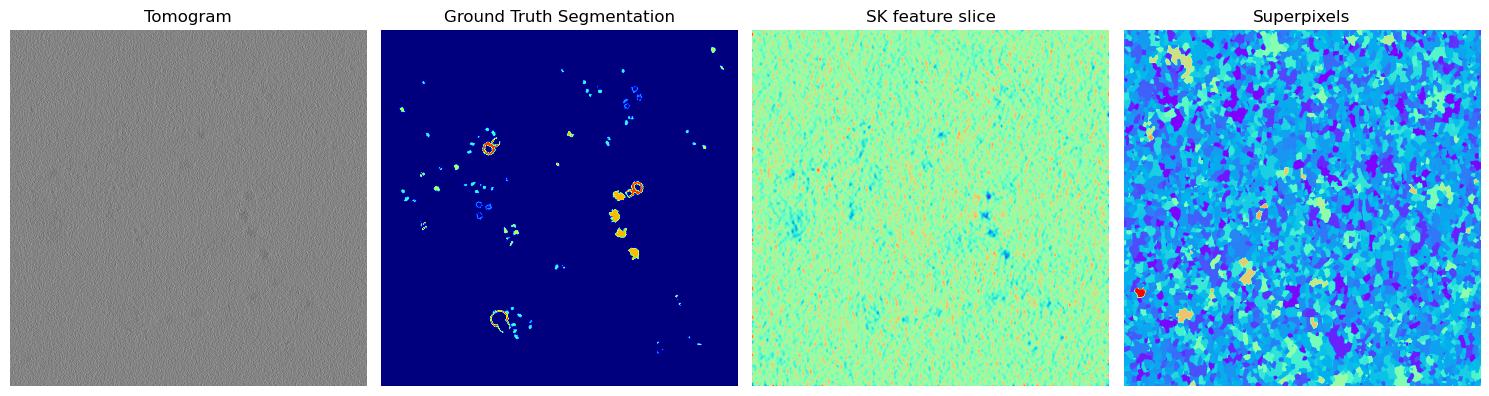

In [4]:
# Plot the images
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title('Tomogram')
plt.imshow(data['image'][20],cmap="gray")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Ground Truth Segmentation')
plt.imshow(data['label'][20], cmap="jet")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('SK feature slice')
plt.imshow(data['sk_features'][10][:,:,10], cmap="rainbow")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Superpixels')
plt.imshow(data['superpixels'][20], cmap="rainbow")
plt.axis('off')

plt.tight_layout()
plt.show()

# 1) Regionprop features

Get the regionprops features

In [5]:
df_features = superpixel_regionprops_features(data['image'], data['superpixels'])
df_features = df_features.set_index('label')
df_features = df_features.drop(columns=['bbox-0','bbox-1','bbox-2','bbox-3','bbox-4','bbox-5','centroid-0','centroid-1','centroid-2'])  
df_features

,area,bbox_area,equivalent_diameter,euler_number,extent,filled_area,major_axis_length,max_intensity,mean_intensity,min_intensity,std_intensity
label,,,,,,,,,,,
32,112.0,210.0,5.980532,1,0.533333,112.0,8.444239,4.823471,0.257689,-3.650790,1.855963
91,288.0,630.0,8.193409,1,0.457143,288.0,11.111778,6.322936,0.043411,-6.156930,1.879687
132,328.0,765.0,8.556413,1,0.428758,328.0,19.166001,4.937047,0.184840,-5.351360,1.798255
160,436.0,648.0,9.407971,1,0.672840,436.0,11.052428,6.368319,0.259752,-5.648208,1.895650
184,216.0,495.0,7.444206,1,0.436364,216.0,11.120000,5.648474,-0.019570,-5.152987,2.052318
...,...,...,...,...,...,...,...,...,...,...,...
79379856,557.0,1428.0,10.208271,1,0.390056,557.0,17.467118,7.297158,0.086839,-5.704575,1.921056
79379883,365.0,770.0,8.866756,1,0.474026,365.0,16.759228,5.803542,-0.156602,-5.668046,1.985156
79379894,102.0,160.0,5.796963,1,0.637500,102.0,9.151707,3.536070,-0.249367,-3.581895,1.624249


Get the ground-truth column

In [6]:
df_gt = ground_truth_count(superpixels=data['superpixels'],ground_truth=data['label'])
df_gt

,ground_truth
label,
32,0
91,0
132,0
160,0
184,0
...,...
79379856,0
79379883,0
79379894,0


Combine features + gt

In [7]:
df_combined = pd.concat([df_features, df_gt],axis=1)

print(df_features.shape)
print(df_gt.shape)
print(df_combined.shape)

df_combined


(40798, 11)
(40798, 1)
(40798, 12)


,area,bbox_area,equivalent_diameter,euler_number,extent,filled_area,major_axis_length,max_intensity,mean_intensity,min_intensity,std_intensity,ground_truth
label,,,,,,,,,,,,
32,112.0,210.0,5.980532,1,0.533333,112.0,8.444239,4.823471,0.257689,-3.650790,1.855963,0
91,288.0,630.0,8.193409,1,0.457143,288.0,11.111778,6.322936,0.043411,-6.156930,1.879687,0
132,328.0,765.0,8.556413,1,0.428758,328.0,19.166001,4.937047,0.184840,-5.351360,1.798255,0
160,436.0,648.0,9.407971,1,0.672840,436.0,11.052428,6.368319,0.259752,-5.648208,1.895650,0
184,216.0,495.0,7.444206,1,0.436364,216.0,11.120000,5.648474,-0.019570,-5.152987,2.052318,0
...,...,...,...,...,...,...,...,...,...,...,...,...
79379856,557.0,1428.0,10.208271,1,0.390056,557.0,17.467118,7.297158,0.086839,-5.704575,1.921056,0
79379883,365.0,770.0,8.866756,1,0.474026,365.0,16.759228,5.803542,-0.156602,-5.668046,1.985156,0
79379894,102.0,160.0,5.796963,1,0.637500,102.0,9.151707,3.536070,-0.249367,-3.581895,1.624249,0


In [8]:
df_combined.ground_truth.max()

7

Do the evaluation

In [34]:
df_try = df_combined.copy()
print(df_try.shape)
# df_try = df_try[df_try.ground_truth>0]  #remove background superpixels

output = evaluate_spp_features(df_try,
            class_weight = 'balanced',
            n_estimators=50,
            n_jobs=-1,
            max_depth=10,
            max_samples=0.05,)#, class_weight='balanced',kernel='linear')

(40798, 12)
Kappa: 0.22450024157815995
Confusion: [[21548   106   471   860   128  3503   259    65]
 [  741   385    38    85    13   197   272    74]
 [  771     6   179    85    17   369    47    47]
 [ 2054    35   112   292    59   619   144   111]
 [  686    11    56    99    81   235    40    30]
 [  811     4    75    86     9   817    43    66]
 [  976   238    61   138    24   325   406   239]
 [  518    71    35    87    22   263   207   347]]


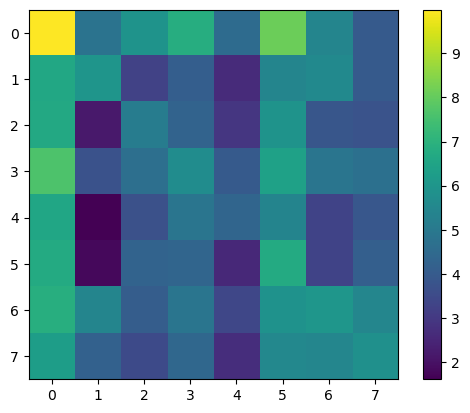

In [28]:
plt.figure()
plt.imshow(np.log1p(output.confusion_matrix))
plt.colorbar()
plt.show()

In [ ]:
plt.hist()

In [ ]:
plt.figure()
plt.hist(df_try.ground_truth.values,7)
plt.show()

# 2) CellCanvas embedding features

In [ ]:
# embeddings = zarr.open('/Users/kevin.zhao/Documents/projects/cellcanvas-org/superpixels/copick_10439/albumImportFromCryoETDataPortal_swinunet-embedding-16194_features.zarr', mode='r')[:]
embeddings = zarr.open('/Users/teun.huijben/Documents/code/github/superpixels/data/copick_10439/albumImportFromCryoETDataPortal_swinunet-embedding-16194_features.zarr')

df_embed = superpixel_cellcanvas_features(embeddings, data["superpixels"])
print(df_embed)

In [29]:
df_embed.describe()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
count,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000,...,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000,40798.000000
mean,0.013952,0.705007,-0.000851,0.483564,0.011753,0.535381,0.029315,0.024926,0.026908,1.021942,...,0.023984,0.005871,0.033630,0.811193,0.865566,0.024019,0.010274,0.406633,0.006149,0.012646
std,0.103959,0.252101,0.003699,0.092355,0.071938,0.083650,0.075844,0.075828,0.040488,0.399133,...,0.033665,0.014356,0.073215,0.185167,0.270588,0.034685,0.024117,0.074201,0.010411,0.067034
min,-0.004936,-0.020462,-0.007580,-0.001523,-0.006210,-0.035400,-0.014790,-0.003977,-0.001191,-0.025154,...,-0.000896,-0.003043,-0.002890,-0.008781,-0.022461,-0.000815,-0.000956,-0.009216,-0.002915,-0.006630
25%,-0.000293,0.592773,-0.001394,0.431396,-0.000264,0.493774,-0.000535,-0.000059,-0.000078,0.840332,...,-0.000039,-0.000176,-0.000098,0.730957,0.762451,-0.000073,-0.000112,0.381470,-0.000166,-0.000206
50%,-0.000165,0.742188,-0.000995,0.487915,-0.000117,0.538574,-0.000068,0.005371,0.012695,1.084961,...,0.012039,-0.000048,0.007812,0.832031,0.913818,0.011719,-0.000020,0.417236,-0.000031,-0.000056
75%,-0.000029,0.865479,-0.000673,0.541016,0.005371,0.584961,0.039104,0.021484,0.037354,1.276367,...,0.034180,0.006836,0.036461,0.920410,1.031250,0.034424,0.009766,0.447998,0.009766,0.009766
max,3.507812,1.582031,0.371826,0.919434,2.833984,0.980225,2.390625,1.746094,0.379150,2.550781,...,0.453613,0.410156,1.355469,1.585938,1.779297,0.358887,0.273682,0.681885,0.125977,2.666016


In [35]:
df_combined_embed = pd.concat([df_embed, df_gt],axis=1)
df_combined_embed.shape

(40798, 49)

In [42]:
output_embed = evaluate_spp_features(df_combined_embed,
            class_weight = 'balanced',
            n_estimators=50,
            n_jobs=-1,
            max_depth=10,
            max_samples=0.05,
)

Kappa: 0.20549082505367855
Confusion: [[24449   281   105   715    31   845   388   126]
 [ 1180   141     9    84     4    49   270    68]
 [ 1108    47    11    86     7    95   118    49]
 [ 2416    79    25   301    23   169   324    89]
 [  832    24    12    81    32    71   153    33]
 [ 1326    29    16    68     3   371    65    33]
 [ 1216   130    11   129    14   104   704    99]
 [  813    61     3    85     7    84   295   202]]


In [43]:
cm = output_embed.confusion_matrix
cm = cm.to_numpy()
cm

array([[24449,   281,   105,   715,    31,   845,   388,   126],
       [ 1180,   141,     9,    84,     4,    49,   270,    68],
       [ 1108,    47,    11,    86,     7,    95,   118,    49],
       [ 2416,    79,    25,   301,    23,   169,   324,    89],
       [  832,    24,    12,    81,    32,    71,   153,    33],
       [ 1326,    29,    16,    68,     3,   371,    65,    33],
       [ 1216,   130,    11,   129,    14,   104,   704,    99],
       [  813,    61,     3,    85,     7,    84,   295,   202]])

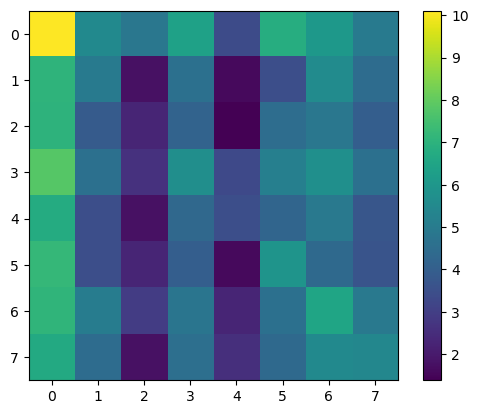

In [38]:
plt.figure()
plt.imshow(np.log1p(cm))
plt.colorbar()
plt.show()